# About
* GBDT Models baseline
    * LightGBM, XGBoost, CatBoost
    * each model is trained by 5 folds cross validation 
* no feature engineering
* inference test by averaging 3 GBDT Models

# Prepare

## import libraries

In [ ]:
import os
import sys
import time
import random
import logging
import typing as tp
from pathlib import Path
from contextlib import contextmanager

from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error, mean_squared_error

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoost, Pool

%matplotlib inline

## read data

In [ ]:
ROOT = Path.cwd().parent
INPUT = ROOT / "input"
DATA = INPUT / "tabular-playground-series-jan-2021"
WORK = ROOT / "working"

for path in DATA.iterdir():
    print(path.name)

In [ ]:
train = pd.read_csv(DATA / "train.csv")
test = pd.read_csv(DATA / "test.csv")
smpl_sub = pd.read_csv(DATA / "sample_submission.csv")
print("train: {}, test: {}, sample sub: {}".format(
    train.shape, test.shape, smpl_sub.shape
))

In [ ]:
train.head().T

## Definition

In [ ]:
@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time.time()
    yield
    d = time.time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

In [ ]:
class TreeModel:
    """Wrapper for LightGBM/XGBoost/CATBoost"""
    def __init__(self, model_type: str):
        self.model_type = model_type
        self.trn_data = None
        self.val_data = None
        self.model = None

    def train(self,
              params: dict,
              X_train: pd.DataFrame, y_train: np.ndarray,
              X_val: pd.DataFrame, y_val: np.ndarray,
              train_weight: tp.Optional[np.ndarray] = None,
              val_weight: tp.Optional[np.ndarray] = None,
              train_params: dict = {}):
        if self.model_type == "lgb":
            self.trn_data = lgb.Dataset(X_train, label=y_train, weight=train_weight)
            self.val_data = lgb.Dataset(X_val, label=y_val, weight=val_weight)
            self.model = lgb.train(params=params,
                                   train_set=self.trn_data,
                                   valid_sets=[self.trn_data, self.val_data],
                                   **train_params)
        elif self.model_type == "xgb":
            self.trn_data = xgb.DMatrix(X_train, y_train, weight=train_weight)
            self.val_data = xgb.DMatrix(X_val, y_val, weight=val_weight)
            self.model = xgb.train(params=params,
                                   dtrain=self.trn_data,
                                   evals=[(self.trn_data, "train"), (self.val_data, "val")],
                                   **train_params)
        elif self.model_type == "cat":
            self.trn_data = Pool(X_train, label=y_train, group_id=[0] * len(X_train))
            self.val_data =  Pool(X_val, label=y_val, group_id=[0] * len(X_val))
            self.model = CatBoost(params)
            self.model.fit(
                self.trn_data, eval_set=[self.val_data], use_best_model=True, **train_params)
        else:
            raise NotImplementedError

    def predict(self, X: pd.DataFrame):
        if self.model_type == "lgb":
            return self.model.predict(
                X, num_iteration=self.model.best_iteration)  # type: ignore
        elif self.model_type == "xgb":
            X_DM = xgb.DMatrix(X)
            return self.model.predict(
                X_DM, ntree_limit=self.model.best_ntree_limit)  # type: ignore
        elif self.model_type == "cat":
            return self.model.predict(X)
        else:
            raise NotImplementedError

    @property
    def feature_names_(self):
        if self.model_type == "lgb":
            return self.model.feature_name()
        elif self.model_type == "xgb":
            return list(self.model.get_score(importance_type="gain").keys())
        elif self.model_type == "cat":
             return self.model.feature_names_
        else:
            raise NotImplementedError

    @property
    def feature_importances_(self):
        if self.model_type == "lgb":
            return self.model.feature_importance(importance_type="gain")
        elif self.model_type == "xgb":
            return list(self.model.get_score(importance_type="gain").values())
        elif self.model_type == "cat":
            return self.model.feature_importances_
        else:
            raise NotImplementedError

# Training & Inference

## Config 

In [ ]:
ID_COL = "id"
FEAT_COLS = [f"cont{i}" for i in range(1, 15)]
TGT_COL = "target"

N_SPLITS = 7#5
RANDOM_SEED_LIST = [
    42,
#     2021, 0, 1086, 39
]

MODEL_PARAMS = {
    "lgb": {
        "objective": "root_mean_squared_error",
        "boosting": "gbdt",
        "learning_rate": 0.1,
        "seed": RANDOM_SEED_LIST[0],
        'max_depth': 7,
        'colsample_bytree': .85,
        "subsample": .85,
        "n_jobs": 2,
        # "device": "gpu",
        # "gpu_device_id": 0
    },
    "xgb": {
        "objective": "reg:squarederror",
        "learning_rate": 0.05,
        "seed": RANDOM_SEED_LIST[0],
        "max_depth": 7,
        "subsample": .85,
        "colsample_bytree": .85,
        "n_jobs": 2,
        'tree_method': "gpu_hist",
        "gpu_id": 0,
    },
    "cat": {
        'loss_function': 'RMSE',
        'learning_rate': 0.1,
        'max_depth': 7,
        'random_state': RANDOM_SEED_LIST[0],
        "thread_count": 2,
        # "task_type": "GPU",
        # "devices" : "0",
        'num_boost_round': 20000
    }
}
TRAIN_PARAMS = {
    "lgb": {
        "num_boost_round": 20000,
        "early_stopping_rounds": 100,
        "verbose_eval": 100,
    },
    "xgb": {
        "num_boost_round": 20000,
        "early_stopping_rounds": 100,
        "verbose_eval":  100,
    },
    "cat": {'early_stopping_rounds': 100, 'verbose_eval': 100}
}

## Feature Engineering

In [ ]:
use_feat_cols = []
train_feat = train[[ID_COL]].copy()
test_feat = test[[ID_COL]].copy()

### raw features

In [ ]:
train_feat = pd.concat([
    train_feat, train[FEAT_COLS]], axis=1)
test_feat = pd.concat([
    test_feat, test[FEAT_COLS]], axis=1)
use_feat_cols.extend(FEAT_COLS)

## Training

In [ ]:
def run_train_and_inference(X, X_test, y, use_model, model_params, train_params, seed_list, n_splits):
    
    oof_pred_arr = np.zeros(len(X))
    test_pred_arr = np.zeros(len(X_test))
    feature_importances = pd.DataFrame()
    score_list = []
    
    for seed in seed_list:
        if use_model == "cat":
            model_params['random_state'] = seed
        else:
            model_params["seed"] = seed
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
        tmp_oof_pred = np.zeros(len(X))
        tmp_test_pred = np.zeros(len(X_test))

        for fold, (trn_idx, val_idx) in enumerate(kf.split(X, y)):
            print("*" * 100)
            print(f"Seed: {seed} - Fold: {fold}")
            X_trn = X.loc[trn_idx].reset_index(drop=True)
            X_val = X.loc[val_idx].reset_index(drop=True)
            y_trn = y[trn_idx]
            y_val = y[val_idx]

            model = TreeModel(model_type=use_model)
            with timer(prefix="Model training"):
                model.train(
                    params=model_params, X_train=X_trn, y_train=y_trn,
                    X_val=X_val, y_val=y_val, train_params=train_params)
            fi_tmp = pd.DataFrame()
            fi_tmp["feature"] = model.feature_names_
            fi_tmp["importance"] = model.feature_importances_
            fi_tmp["fold"] = fold
            fi_tmp["seed"] = seed
            feature_importances = feature_importances.append(fi_tmp)

            val_pred = model.predict(X_val)
            score = mean_squared_error(y_val, val_pred, squared=False)
            print(f"score: {score:.5f}")
            score_list.append([seed, fold, score])
            tmp_oof_pred[val_idx] = val_pred
            tmp_test_pred += model.predict(X_test)
            
        oof_score = mean_squared_error(y, tmp_oof_pred, squared=False)
        print(f"oof score: {oof_score: 5f}")
        score_list.append([seed, "oof", oof_score])

        oof_pred_arr += tmp_oof_pred
        test_pred_arr += tmp_test_pred / n_splits

    oof_pred_arr /= len(seed_list)
    test_pred_arr /= len(seed_list)
    
    oof_score = mean_squared_error(y, oof_pred_arr, squared=False)
    score_list.append(["avg", "oof", oof_score])
    score_df = pd.DataFrame(
        score_list, columns=["seed", "fold", "rmse score"])
    
    return oof_pred_arr, test_pred_arr, score_df, feature_importances

In [ ]:
X = train_feat[use_feat_cols]
X_test = test_feat[use_feat_cols]

y = train[TGT_COL].values

print(f"train_feat: {X.shape}, test_feat: {X_test.shape}")

### LightGBM

In [ ]:
oof_pred_lgb, test_pred_lgb, score_lgb, feat_imps_lgb = run_train_and_inference(
    X, X_test, y, "lgb", MODEL_PARAMS["lgb"], TRAIN_PARAMS["lgb"], RANDOM_SEED_LIST, N_SPLITS)

In [ ]:
score_lgb

In [ ]:
score_lgb.loc[score_lgb.fold == "oof"]

In [ ]:
order = list(feat_imps_lgb.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feat_imps_lgb, order=order)
plt.title("{} importance".format("lgb"))
plt.tight_layout()

### XGBoost

In [ ]:
oof_pred_xgb, test_pred_xgb, score_xgb, feat_imps_xgb = run_train_and_inference(
    X, X_test, y, "xgb", MODEL_PARAMS["xgb"], TRAIN_PARAMS["xgb"], RANDOM_SEED_LIST, N_SPLITS)

In [ ]:
score_xgb

In [ ]:
score_xgb.loc[score_xgb.fold == "oof"]

In [ ]:
order = list(feat_imps_xgb.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feat_imps_xgb, order=order)
plt.title("{} importance".format("xgb"))
plt.tight_layout()

### CatBoost

In [ ]:
oof_pred_cat, test_pred_cat, score_cat, feat_imps_cat = run_train_and_inference(
    X, X_test, y, "cat", MODEL_PARAMS["cat"], TRAIN_PARAMS["cat"], RANDOM_SEED_LIST, N_SPLITS)

In [ ]:
score_cat

In [ ]:
score_cat.loc[score_cat.fold == "oof"]

In [ ]:
order = list(feat_imps_cat.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feat_imps_cat, order=order)
plt.title("{} importance".format("cat"))
plt.tight_layout()

### Ensemble LGB, XGB, Cat

### check correlation

In [ ]:
model_names = ["lgb", "xgb", "cat"]

In [ ]:
# # prediction for oof
pd.DataFrame(
    np.corrcoef([
        oof_pred_lgb,
        oof_pred_xgb,
        oof_pred_cat
    ]),
    columns=model_names, index=model_names)

In [ ]:
# # prediction for test
pd.DataFrame(
    np.corrcoef([
        test_pred_lgb,
        test_pred_xgb,
        test_pred_cat
    ]),
    columns=model_names, index=model_names)

### averaging

In [ ]:
oof_pred_avg = (oof_pred_lgb + oof_pred_xgb + oof_pred_cat) / 3
oof_score_avg = mean_squared_error(y, oof_pred_avg, squared=False)

print(f"oof score avg: {oof_score_avg:.5f}")

In [ ]:
test_pred_avg = (test_pred_lgb + test_pred_xgb + test_pred_cat) / 3

## Try Prevision.io for FREE during one month : https://cloud.prevision.io

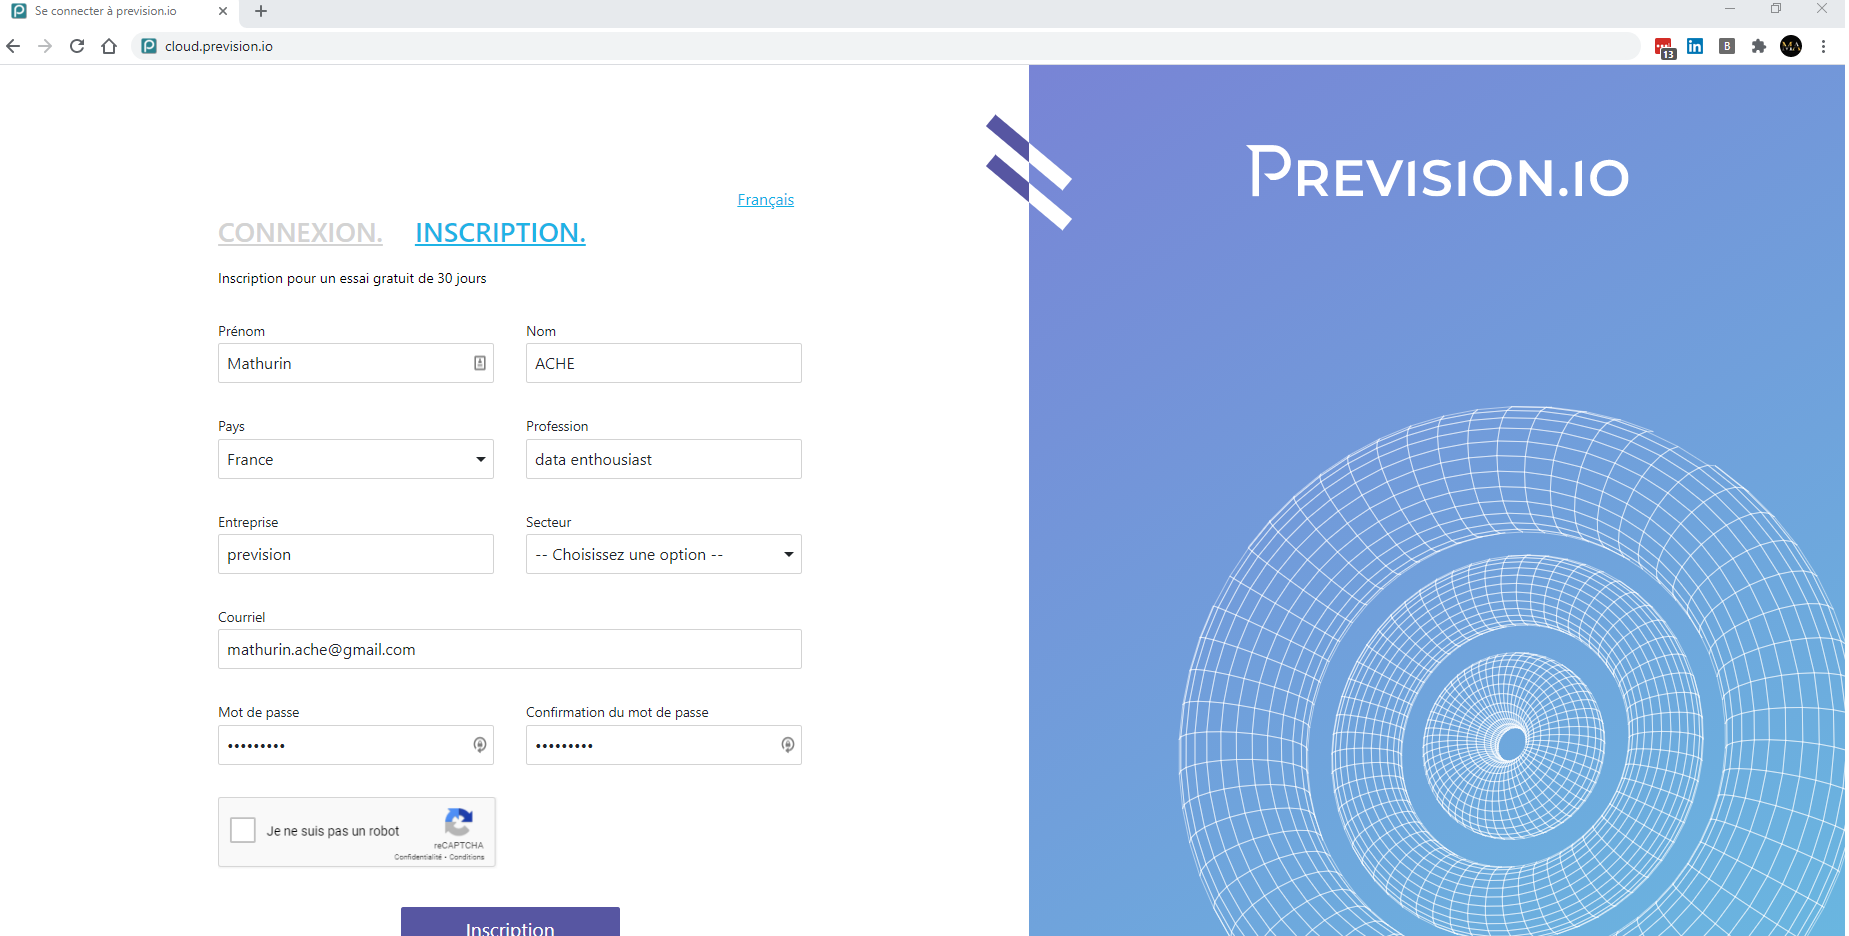

## Prevision.io is on Gartner Magic Quadrant for Cloud AI Developer Services
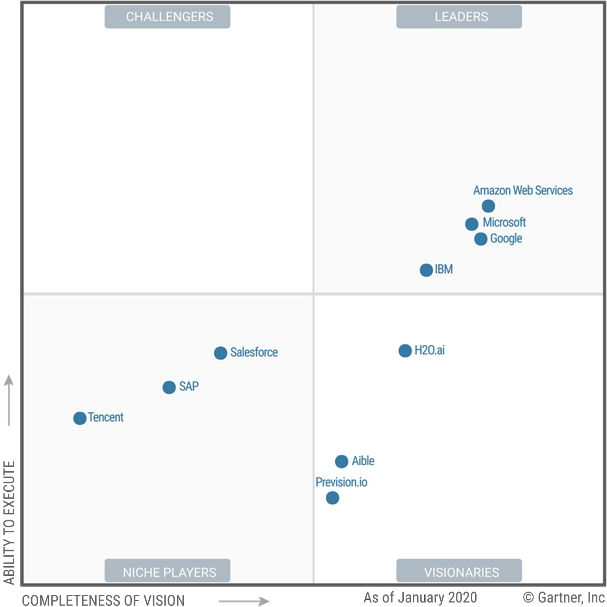

In [ ]:
sub1=pd.read_csv("../input/tabularplayground-previsionio/tabular-playground-series-jan-2021_train-tabular-playground-series-jan-2021_test-BLEND-LR-1-06964.csv")
sub2=pd.read_csv("../input/tabularplayground-previsionio/tabular-playground-series-jan-2021_train-tabular-playground-series-jan-2021_test-BLEND-LR-2-06964.csv")
sub3=pd.read_csv("../input/tabularplayground-previsionio/tabular-playground-series-jan-2021_train-tabular-playground-series-jan-2021_test-MEAN-1-06965.csv")
sub3.head()

In [ ]:
sub = smpl_sub.copy()
sub[TGT_COL] = test_pred_avg*0.25+0.25*sub1[TGT_COL]+0.25*sub2[TGT_COL]+0.25*sub3[TGT_COL] 

sub.to_csv("submission.csv", index=False)

sub.head()